[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dilru1/ner-project/blob/main/projet-2025.ipynb)

In [2]:
# 1. Download the file using the correct "raw" URL
!wget https://raw.githubusercontent.com/Dilru1/ner-project/main/requirements.txt -O requirements.txt

# 2. Install
!pip install -r requirements.txt

--2026-01-15 20:25:42--  https://raw.githubusercontent.com/Dilru1/ner-project/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1422 (1.4K) [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]   1.39K  --.-KB/s    in 0s      

2026-01-15 20:25:43 (21.5 MB/s) - ‘requirements.txt’ saved [1422/1422]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 25.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.9/402.9 kB 26.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pypr

# Building models for named entity recognition

The project consists in building two named entity recognition (NER) systems. The systems will make use of the IOB tagging scheme to detect entities of type PER, ORG, LOC and MISC. The tagging scheme thus includes the following tags, assuming one tag per token:

- B-PER and I-PER: token corresponds to the start, resp. the inside, of a person's entity
- B-LOC and I-LOC: token corresponds to the start, resp. the inside, of a location entity
- B-ORG and I-ORG: token corresponds to the start, resp. the inside, of an organization entity
- B-MISC and I-MISC: token corresponds to the start, resp. the inside, of any other named entity
- O: token corresponds to no entity

## Dataset

You are provided with training, validation and test data derived from the CONLL 03 dataset. The dataset has been marginally cleaned and reformatted for facilitated use. You can directly load the three folds from the json file provided:

```python
with open('conll03-iob-pos.json', 'r') as f:
    data = json.load(f)
```
For each fold, the dataset consists of a list of dictionaries, one per sample, with the two fields 'tokens' and 'labels', e.g.

{'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'tags': ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']}

## TODO

Building on the notebooks we've seen during the lectures and on the tipcs below, you task is to build two tagging models:
1. a RNN-based model: an embedding layer, a LSTM layer, a feed-forward layer
2. a fine-tuned BERT tagger: a BERT (pre-trained) layer, a feed-forward layer
The final feed-forward layer procudes a probability distribution over the set possible tags for each input token.

For both, we will use BERT's tokenizer, which is a sub-word tokenizer. The advantage of this tokenizer is that the vocabulary is finite (no out-of-vocabulary tokens): you can get the vocabulary size from tokenizer.vocab_size and you don't have to bother with defining your vocabulary and mapping unkown tokens to some special token. The disadvantage of sub-word tokenization is that we will have to relabel the input sequences, which are labeled on a word basis rather than on a sub-word basis. To make things easier, we provide a function that aligns and encode the labels. Note that special tokens will arbitrarily get the tag -100 which is a default value to indicate Torch's loss functions that gradient should not be propagated from there (in other words, ignore thos tokens in training).

Another advantage of using the same tokenizer is that you will have to prepare your dataset and the corresponding loaders only once for the two models.

Here are the steps you'll have to go through:

1. Define a Dataset class that will hold for each sample the list of encoded tokens and the corresponding list of encoded tags. You will then encode the three folds as a Dataset and define the corresponding DataLoader instances.

2. Define your LSTM model class and train it. You can get inspired by the RNN language model notebook.

3. Define your BERT model class and train it. You can adapt the LLM finetuning notebook, changing the classification head to operate on each token (as for the LSTM) rather than on the embedding of the [CLS] token.

4. Evaluate both and compare. Token tag accuracy is one measure (used for instance to measure the convergence of training) but it's not the ultimate one as the final task is not to tag tokens but to detect entities. You should thus also report in the final evaluation the entitu recognition rate.

One last thing to think about: computation of the accuracy for validation and testing must be adapted in two ways compared to what we've seen in the previous notebooks. First, each prediction is a sequence of tags and not a single tag. Second, tags corresponding to the special tokens (indicated as -100 in the reference) must not be accounted for when computing the accuracy (maybe pytorch does that for you but you have to make sure it does).

**Good luck no your mission!**

## REPORT

The report will be a commented notebook. This is not a python programing project but a NLP project. I'm thus expecting you to comment on your model definition choices, to analyze the results and errors, to provide hints at how things could be improved. If you did trial and error cells, please clean up a bit to facilitate reading, leaving only the final version in the report notebook.



In [3]:
import json
import gzip

from transformers import AutoModel, AutoTokenizer

from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import Dataset, DataLoader


#load the data

In [4]:
import os
import json
import gzip
import sys
from pathlib import Path

# 1. Detect Google Colab
IN_COLAB = 'google.colab' in sys.modules

# 2. Define Paths
project_root = os.getcwd()
data_dir = Path(project_root) / "data"
data_filename = "conll03-iob-pos.json.gz"
data_path = data_dir / data_filename

# 3. Colab-Specific Logic
if IN_COLAB:
    print("Detected Google Colab environment.")

    # Create 'data' folder if missing
    if not data_dir.exists():
        data_dir.mkdir(parents=True, exist_ok=True)
        print(f"Created directory: {data_dir}")

    # Download file if missing
    if not data_path.exists():
        print(f"Downloading {data_filename}...")

        # CRITICAL: Use the 'raw' URL (no 'blob')
        url = "https://raw.githubusercontent.com/Dilru1/ner-project/main/data/conll03-iob-pos.json.gz"

        # -O specifies the output path
        exit_code = os.system(f"wget {url} -O {data_path}")

        if exit_code == 0:
            print("Download successful!")
        else:
            print("Error: Download failed. Check the URL.")
    else:
        print("File already exists in Colab.")

# 4. Load Data
try:
    print(f"Loading data from: {data_path}")
    with gzip.open(data_path, "rt", encoding="utf-8") as f:
        data = json.load(f)

    print(f"Success! Type: {type(data)}")
    print(f"Train samples: {len(data['train'])}")
    print(f"Test samples:  {len(data['test'])}")

except FileNotFoundError:
    print(f"\nCRITICAL ERROR: File not found at {data_path}")
    print("If running locally, please ensure the file exists in the 'data' folder.")

Detected Google Colab environment.
Created directory: /content/data
Download successful!
Loading data from: /content/data/conll03-iob-pos.json.gz
Success! Type: <class 'dict'>
Train samples: 14041
Test samples:  3453


In [5]:
# sample
sample_idx = 10
sample = data['train'][sample_idx]

print(f"Sentence Length: {len(sample['tokens'])} words")
print(f"{'WORD':<15} {'TAG':<10} {'DESCRIPTION'}")

for token, tag in zip(sample['tokens'], sample['tags']):
    # Simple logic to explain the tag for this demo
    desc = "No Entity"
    if tag != 'O':
        desc = f"Entity: {tag.split('-')[1]} ({'Start' if 'B-' in tag else 'Continuation'})"

    print(f"{token:<15} {tag:<10} {desc}")

Sentence Length: 27 words
WORD            TAG        DESCRIPTION
Spanish         B-MISC     Entity: MISC (Start)
Farm            O          No Entity
Minister        O          No Entity
Loyola          B-PER      Entity: PER (Start)
de              I-PER      Entity: PER (Continuation)
Palacio         I-PER      Entity: PER (Continuation)
had             O          No Entity
earlier         O          No Entity
accused         O          No Entity
Fischler        B-PER      Entity: PER (Start)
at              O          No Entity
an              O          No Entity
EU              B-ORG      Entity: ORG (Start)
farm            O          No Entity
ministers       O          No Entity
'               O          No Entity
meeting         O          No Entity
of              O          No Entity
causing         O          No Entity
unjustified     O          No Entity
alarm           O          No Entity
through         O          No Entity
"               O          No Entity
dangerous

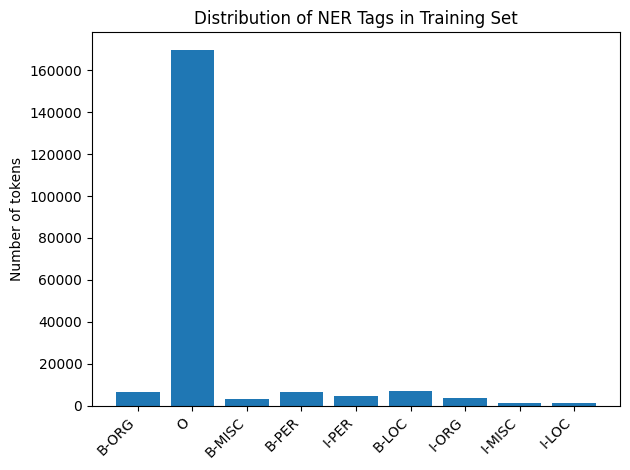

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

# Flatten all tags
all_tags = [tag for sample in data['train'] for tag in sample['tags']]
tag_counts = Counter(all_tags)

tags = list(tag_counts.keys())
counts = list(tag_counts.values())

plt.figure()
plt.bar(tags, counts)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of tokens")
plt.title("Distribution of NER Tags in Training Set")
plt.tight_layout()
plt.show()


In [7]:
# Pick a word that BERT will likely split
word = "embedding"
print(f"Original word: {word}")

# Let's try a third one that is currently being used with deep transformer models.

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# Use the tokenizer you loaded earlier
sub_words = tokenizer.tokenize(word)
print(f"BERT sees:     {sub_words}")

Original word: embedding


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

BERT sees:     ['em', '##bed', '##ding']


In [8]:
#
# tag to id mapping and vice versa
#
# for tokens that does not have a tag, we will use -100 as the corresponding tag ID
#

tag2id = {
    'O': 0,
    'B-LOC': 1, 'I-LOC': 2,
    'B-ORG': 3, 'I-ORG': 4,
    'B-PER': 5, 'I-PER': 6,
    'B-MISC': 7, 'I-MISC': 8
}

id2tag = list(tag2id.keys())

print(id2tag)

['O', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-MISC']


In [9]:
#
# load data from json file
#

with gzip.open('data/conll03-iob-pos.json.gz', 'r') as f:
    data = json.load(f)

for fold in ('train', 'valid', 'test'):
    print(fold, len(data[fold]))

print(data['train'][0])

train 14041
valid 3250
test 3453
{'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'tags': ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']}


In [10]:
#
# load BERT's tokenizer -- this
#
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
print(tokenizer)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [11]:
#
# Here's an example showing how to tokenize texts and create the corresponding aligned and encoded labels
#
# Note that the tokenizer enables to retrieve the index of the corresponding wordform for each (sub-word) token
# through the inputs.word_ids(batch_index=i) function (to retrieve input word indices for each token in
# inputs['input_ids'][i]). Special tokens ([CLS], [SEP], [PAD]) are mapped to None. We will make use of this
# mapping to create token-level labels adapted to sub-word tokenization. See next cell.
#

train_texts = [x['tokens'] for x in data['train']]
train_labels = [x['tags'] for x in data['train']]

inputs = tokenizer(train_texts, is_split_into_words=True, padding=True, truncation=True, return_tensors="pt")

print(train_texts[0])
print(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))
print(inputs.word_ids(batch_index=0))

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[P

In [12]:
def align_and_encode_labels(_token_ids, _word_ids, _labels):
    '''
    Align word-level labels to sub-word tokens for an entry
    '''

    global tag2id

    ignore_id = -100

    buf = [ignore_id] # ignore tag for token [CLS]

    prev_token_word = -1
    which_type = 0

    # print(len(_token_ids), tokenizer.convert_ids_to_tokens(_token_ids))
    # print(_word_ids)
    # print(_labels)

    for i in range(1, len(_token_ids)):
        word_id = _word_ids[i]

        if word_id == None:
            # token does not belong to any input word ([CLS], [SEP] or [PAD]) -- ignore
            buf.append(ignore_id)

        else:
            tag_id = tag2id[_labels[word_id]]

            if word_id == prev_token_word:
            # sub-word token of the previous word: need to do something
            #   word has an O tag: just use a O tag
            #   word has an I-X tag: just use the I-X tag
            #   word has a B-X tag: replace by corresponding I-X tag

                buf.append(tag_id + 1 if tag_id in (1, 3, 5, 7) else tag_id)

            else:
                # token starting a new word --> keep tag unchanged
                prev_token_word = word_id
                buf.append(tag_id)

    return buf

#
# The following illustrate how we can get aligned and encoded labels for sample i in the training set.
#

i = 10

print(train_texts[i], train_labels[i])

new_labels = align_and_encode_labels(inputs['input_ids'][i], inputs.word_ids(batch_index=i), train_labels[i])

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])

for j in range(len(tokens)):
    if tokens[j] != '[PAD]':
        print(tokens[j], ' -- ', id2tag[new_labels[j]] if new_labels[j] >= 0 else 'NONE')

['Spanish', 'Farm', 'Minister', 'Loyola', 'de', 'Palacio', 'had', 'earlier', 'accused', 'Fischler', 'at', 'an', 'EU', 'farm', 'ministers', "'", 'meeting', 'of', 'causing', 'unjustified', 'alarm', 'through', '"', 'dangerous', 'generalisation', '.', '"'] ['B-MISC', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[CLS]  --  NONE
Spanish  --  B-MISC
Farm  --  O
Minister  --  O
Loyola  --  B-PER
de  --  I-PER
Pa  --  I-PER
##la  --  I-PER
##cio  --  I-PER
had  --  O
earlier  --  O
accused  --  O
Fi  --  B-PER
##sch  --  I-PER
##ler  --  I-PER
at  --  O
an  --  O
EU  --  B-ORG
farm  --  O
ministers  --  O
'  --  O
meeting  --  O
of  --  O
causing  --  O
un  --  O
##ju  --  O
##st  --  O
##ified  --  O
alarm  --  O
through  --  O
"  --  O
dangerous  --  O
general  --  O
##isation  --  O
.  --  O
"  --  O
[SEP]  --  NONE


In [13]:
# Now it's up to you to pursue this notebook, define your datasets, models and evaluate.

In [14]:
class NERDataset(Dataset):
    def __init__(self, _data, _tokenizer):

        # _data is the list of dictionaries [{'tokens': [...], 'tags': [...]}, ...]
        self.raw_tokens = [x['tokens'] for x in _data] #words
        self.raw_tags = [x['tags'] for x in _data]   #associated tags

        # Tokenize the sentences (sub-word tokenizer)
        self.encodings = _tokenizer(
            self.raw_tokens,
            is_split_into_words=True, #let the tokenizer know thats sentence is already split
            padding=True, #make all the sequence is same lenght
            truncation=True,  # for long sentence (otherwise bert will crash)
            return_tensors='pt' #return the o/p in Py-torch Tensor
        )

        # Generate a list of label ids matching the new sub-word tokens
        self.labels = []
        for i in range(len(_data)):
            # get the alignment info (word_ids) for this specific sample
            word_ids = self.encodings.word_ids(batch_index=i)
            token_ids = self.encodings['input_ids'][i] #get the token ids like [CLS], [SEP], [PAD]


            # convert token_ids to list because the helper expects a list
            aligned_label = align_and_encode_labels(token_ids.tolist(), word_ids, self.raw_tags[i])

            self.labels.append(aligned_label)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)



#tok_fn =  lambda x: tokenizer(x, is_split_into_words=True, truncation=True, padding=True) #tokenization logic was moved into the class
tok_fn = tokenizer


# Initialize datasets using the "data" dictionary
ds = dict()
ds['train'] = NERDataset(data['train'], tok_fn)
ds['valid'] = NERDataset(data['valid'], tok_fn)
ds['test'] = NERDataset(data['test'], tok_fn)

# Create Pytorch DataLoaders
# DataLoaders will create the traning batches for later models
train_loader = DataLoader(ds['train'], batch_size=32, shuffle=True)
valid_loader = DataLoader(ds['valid'], batch_size=32)
test_loader = DataLoader(ds['test'], batch_size=32)

#### use case

In [ ]:
# get a single batch from the training loader
batch = next(iter(train_loader)) #create iterator and take the very first batch

/tmp/ipykernel_125759/1044874283.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
# Both input_ids and labels have the shape of #(Batch_Size, Sequence_Length)
print(f"Input Shape: {batch['input_ids'].shape}")
print(f"Label Shape: {batch['labels'].shape}")


# first sentence in this batch
input_ids = batch['input_ids'][0]
labels = batch['labels'][0]

# Convert IDs back to words so we can read them
tokens = tokenizer.convert_ids_to_tokens(input_ids)

for token, label_id in zip(tokens, labels):
    if token != '[PAD]': # non padding tokens for cleaner output
        label_name = id2tag[label_id.item()] if label_id.item() != -100 else "IGNORE"
        print(f"{token:<15} {label_id.item():<10} {label_name}")

Input Shape: torch.Size([32, 173])
Label Shape: torch.Size([32, 173])
[CLS]           -100       IGNORE
Ipswich         3          B-ORG
,               0          O
Port            3          B-ORG
Vale            4          I-ORG
v               0          O
Oxford          3          B-ORG
,               0          O
Reading         3          B-ORG
v               0          O
Stoke           3          B-ORG
,               0          O
South           3          B-ORG
##end           4          I-ORG
v               0          O
[SEP]           -100       IGNORE


### LSTM MODEL

In [ ]:
import torch.nn as nn

class LSTM_NER(torch.nn.Module):

    def __init__(self, vocsize, n_tags, embed_dim=200, hidden_dim=256, dropout=0.25):
        super(LSTM_NER, self).__init__()

        self.vocabulary_size = vocsize
        self.nclasses = n_tags

        # Embedding Layer
        self.embedding = torch.nn.Embedding(vocsize, embed_dim, padding_idx=0) #padding_idx=0 becuase BERT pad token id is 0)

        # LSTM Layer (Output dim = hidden_dim * 2)
        self.rnn = torch.nn.LSTM(embed_dim,
                                 hidden_dim,
                                 batch_first=True,
                                 bidirectional=True, # 2 hidden states per token (Left->Right & Right->Left)
                                 dropout=dropout if dropout else 0)

        # Dropout
        self.dropout = torch.nn.Dropout(dropout) if dropout else None

        # Linear Layer |  Input: hidden_dim * 2 , Output: n_tags
        self.linear = torch.nn.Linear(hidden_dim * 2, n_tags)

    def forward(self, input_ids, **kwargs):
        x = self.embedding(input_ids)  # input_ids shape: [batch_size, seq_len]

        if self.dropout is not None:
            x = self.dropout(x)

        # Data run via Bi-LSTM
        x, _ = self.rnn(x) # x shape: (batch_size, seq_len, hidden_dim * 2)

        if self.dropout is not None:
            x = self.dropout(x)

        # Data project to Tag probabilities
        x = self.linear(x) # x shape: (batch_size, seq_len, n_tags)

        # Permute for Loss Function (swap dimensions 1 and 2)
        return x.permute(0, 2, 1)  # because loss function wants batch_size * nclasses * maxlen




# Hyperparameters
INPUT_DIM = tokenizer.vocab_size  # ~29,000 (from BERT tokenizer)
OUTPUT_DIM = len(tag2id)          # 9 tags (O, B-PER, etc.)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
DROPOUT = 0.25

# Initialize Model
lstm_model = LSTM_NER(INPUT_DIM, OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, DROPOUT)



/home/ensai/Desktop/NLP/nlp.env/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


### Lets see the model

In [ ]:
def train_step(_model, _loader, _loss, _optim, device="cpu", report=0):
    '''
    NER Training step.
    Adapted to handle sequence labels (NER tags) and the 'labels' dictionary key.
    '''
    _model.train(True)
    total_loss = 0.
    running_loss = 0.

    for i, batch in enumerate(_loader):
        _optim.zero_grad()

        # CHANGE: Use 'labels' (plural) to match NERDataset
        labels = batch['labels'].to(device)

        # CHANGE: Filter out 'labels' to get inputs (input_ids, attention_mask)
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}

        # Forward pass
        # The LSTM_NER model we defined accepts **inputs (input_ids is required)
        outputs = _model(**inputs)

        # Calculate loss
        # outputs shape: [Batch, Classes, Seq_Len] (due to permute in model)
        # labels shape:  [Batch, Seq_Len]
        # CrossEntropyLoss handles this automatically
        loss = _loss(outputs, labels)

        total_loss += loss.item()
        running_loss += loss.item()

        loss.backward()
        _optim.step()

        if report != 0 and i % report == report - 1:
            print('  batch {} avg. loss per batch={:.4f}'.format(i + 1, running_loss / report))
            running_loss = 0.

    _model.train(False)

    return total_loss

def eval_step(_model, _loader, _loss, device='cpu'):
    '''
    Evaluate the NER model's performance (Validation Loss).
    '''
    _model.eval()
    total_loss = 0.

    for batch in _loader:
        # CHANGE: Use 'labels' (plural)
        labels = batch['labels'].to(device)

        # CHANGE: Filter out 'labels'
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}

        with torch.no_grad():
            outputs = _model(**inputs)

        # Calculate validation loss
        loss = _loss(outputs, labels)
        total_loss += loss.item()

    # Return average loss per batch
    return total_loss / len(_loader)

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

# ---------------------------------------------------------
# 1. PARAMETERS
# ---------------------------------------------------------
lr = 1e-3           # 1e-3 is standard for LSTMs (BERT uses much lower, e.g. 5e-5)
nepochs = 5         # NER learns fast. 20 is usually too many.
report_freq = 10    # Print stats every 10 batches
batch_size = 32

# ---------------------------------------------------------
# 2. DEVICE CHECK
# ---------------------------------------------------------
#if torch.backends.mps.is_built():
#    device = "mps"
#    torch.mps.empty_cache()
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = "cpu"
print(f'Running on {device} device')



lstm_model = lstm_model.to(device)
# ---------------------------------------------------------
# 3. OPTIMIZER & LOSS
# ---------------------------------------------------------
# We optimize the parameters of our lstm_model defined in Step 2
optimizer = optim.Adam(lstm_model.parameters(), lr=lr)

# CRITICAL: -100 tells PyTorch to ignore padding and sub-word parts (##ing)
celoss = torch.nn.CrossEntropyLoss(ignore_index=-100)

# ---------------------------------------------------------
# 4. DATA LOADERS
# ---------------------------------------------------------
# We put them in a dictionary to match your style
loader = dict()

# Note: ds['train'], ds['valid'], etc. were defined in Step 1
loader['train'] = DataLoader(ds['train'], batch_size=batch_size, shuffle=True)
loader['valid'] = DataLoader(ds['valid'], batch_size=batch_size)
loader['test']  = DataLoader(ds['test'],  batch_size=batch_size)

Running on cuda device


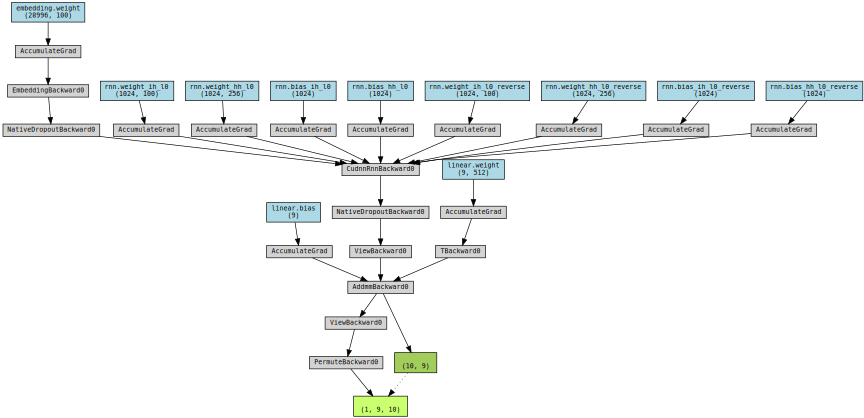

In [ ]:
from torchviz import make_dot
import torch

# 1. Create dummy input (Batch Size 1, Sequence Length 10)
# We use the same 'device' variable defined in the training step
dummy_input = torch.randint(
    0, tokenizer.vocab_size, (1, 10)
).to(device)

# 2. Pass it through the model
output = lstm_model(dummy_input)

# 3. Generate the Graph
# This traces how data flows from input -> embedding -> lstm -> linear
make_dot(output, params=dict(lstm_model.named_parameters()))

--- STARTING TRAINING ---
  batch 10 avg. loss per batch=0.0811


/tmp/ipykernel_125759/1044874283.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  batch 20 avg. loss per batch=0.0832
  batch 30 avg. loss per batch=0.0872
  batch 40 avg. loss per batch=0.1022
  batch 50 avg. loss per batch=0.0762
  batch 60 avg. loss per batch=0.0892
  batch 70 avg. loss per batch=0.0795
  batch 80 avg. loss per batch=0.0905
  batch 90 avg. loss per batch=0.0785
  batch 100 avg. loss per batch=0.0873
  batch 110 avg. loss per batch=0.0876
  batch 120 avg. loss per batch=0.0956
  batch 130 avg. loss per batch=0.0893
  batch 140 avg. loss per batch=0.0944
  batch 150 avg. loss per batch=0.0968
  batch 160 avg. loss per batch=0.0866
  batch 170 avg. loss per batch=0.0973
  batch 180 avg. loss per batch=0.0789
  batch 190 avg. loss per batch=0.0949
  batch 200 avg. loss per batch=0.0831
  batch 210 avg. loss per batch=0.0810
  batch 220 avg. loss per batch=0.0904
  batch 230 avg. loss per batch=0.0833
  batch 240 avg. loss per batch=0.0945
  batch 250 avg. loss per batch=0.0968
  batch 260 avg. loss per batch=0.0916
  batch 270 avg. loss per batch=0

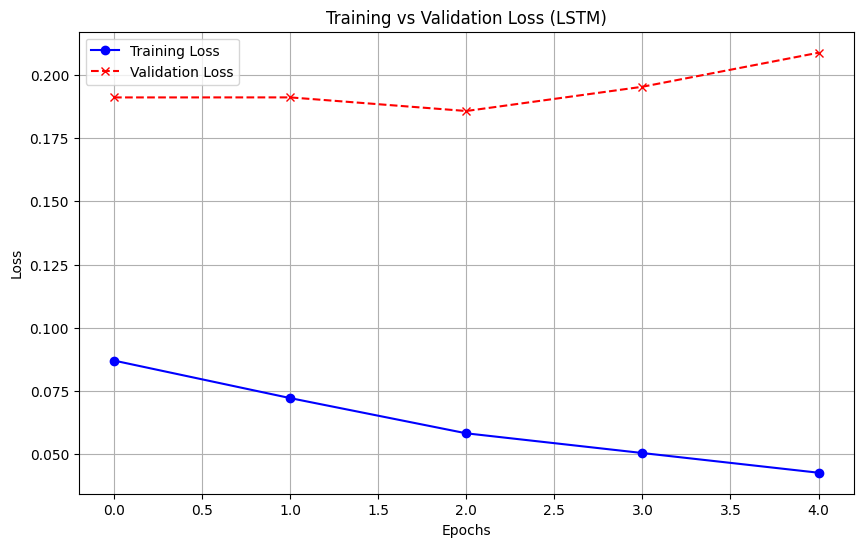

In [ ]:
import matplotlib.pyplot as plt

# 1. Initialize lists to store the history
train_losses = []
valid_losses = []

print("--- STARTING TRAINING ---")

for epoch in range(nepochs):
    # --- TRAIN ---
    total_train_loss = train_step(lstm_model, loader['train'], celoss, optimizer, device=device, report=report_freq)
    avg_train_loss = total_train_loss / len(loader['train'])

    # --- VALIDATE ---
    # Remember: eval_step already returns the average
    avg_valid_loss = eval_step(lstm_model, loader['valid'], celoss, device=device)

    # --- STORE METRICS ---
    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)

    # Print simple progress so you know it's not frozen
    #print(f'Epoch {epoch+1:02} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f}')

# ---------------------------------------------------------
# DRAW THE GRAPH
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# Plot Training Loss (Blue)
plt.plot(train_losses, label='Training Loss', marker='o', color='blue')

# Plot Validation Loss (Red)
plt.plot(valid_losses, label='Validation Loss', marker='x', color='red', linestyle='--')

plt.title('Training vs Validation Loss (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Save and Load the model



In [ ]:
import os

# Create the directory if it doesn't exist (good practice)
output_dir = 'model_checkpoints'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the filename
save_path = f'{output_dir}/lstm_ner_model.pt'

# Save the model's state_dict (the weights)
print(f"Saving model to {save_path}...")
torch.save(lstm_model.state_dict(), save_path)
print("Saved successfully!")

Saving model to model_checkpoints/lstm_ner_model.pt...
Saved successfully!


In [ ]:
# 1. Define the path where you saved it
load_path = 'model_checkpoints/lstm_ner_model.pt'

# 2. Instantiate the blank model structure first
# (Ensure INPUT_DIM, OUTPUT_DIM, etc. are defined exactly as they were during training)
loaded_model = LSTM_NER(INPUT_DIM, OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, DROPOUT)
loaded_model = loaded_model.to(device)

# 3. Load the weights
print(f"Loading weights from {load_path}...")
loaded_model.load_state_dict(torch.load(load_path, map_location=device))

# 4. Set to evaluation mode (Critical! Turns off Dropout)
loaded_model.eval()
print("Model loaded and ready for testing!")

Loading weights from model_checkpoints/lstm_ner_model.pt...
Model loaded and ready for testing!


/home/ensai/Desktop/NLP/nlp.env/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


# BERT MODEL


In [ ]:
from seqeval.metrics import classification_report, f1_score, accuracy_score

def evaluate_model(model, iterator, device):
    model.eval()

    true_tags = []
    pred_tags = []

    with torch.no_grad():
        for batch in iterator:
            ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            predictions = model(ids) # Shape: [batch, seq_len, num_tags]

            # Get the max probability for each token
            # Shape: [batch, seq_len]
            predictions = torch.argmax(predictions, dim=2)

            # Move to CPU for list manipulation
            predictions = predictions.detach().cpu().numpy()
            labels = labels.cpu().numpy()

            # Convert IDs to Tag Names, ignoring -100
            for i in range(len(labels)):
                temp_true = []
                temp_pred = []

                for j in range(len(labels[i])):
                    # Only keep the label if it's NOT -100 (ignore padding/sub-words)
                    if labels[i][j] != -100:
                        temp_true.append(id2tag[labels[i][j]])
                        temp_pred.append(id2tag[predictions[i][j]])

                true_tags.append(temp_true)
                pred_tags.append(temp_pred)

    return true_tags, pred_tags

In [ ]:
# 1. Get predictions
print("Running evaluation on Test Set...")
true_tags, pred_tags = evaluate_model(lstm_model, test_loader, device)

# 2. Print the detailed classification report
print("\n--- NER CLASSIFICATION REPORT ---")
print(classification_report(true_tags, pred_tags))

# 3. Print summary metrics
print(f"Entity F1-Score: {f1_score(true_tags, pred_tags):.2f}")
print(f"Token Accuracy:  {accuracy_score(true_tags, pred_tags):.2f}")

In [ ]:
# Compare the first 3 sentences of the test set
for i in range(3):
    print(f"\nExample {i}:")
    print(f"{'WORD':<15} {'TRUE':<10} {'PRED'}")
    print("-" * 35)

    # We need the original words to make this readable
    # Note: This simple retrieval works because our lists are aligned
    for word, true, pred in zip(true_tags[i], true_tags[i], pred_tags[i]):
        # We perform a rough zip here; for a perfect word-match you'd need the original tokens
        # But for checking tags vs preds, this is sufficient
        print(f"{'token':<15} {true:<10} {pred}")

## BERT model

In [ ]:
import torch.nn as nn
from transformers import AutoModel

class BERT_NER(nn.Module):
    def __init__(self, checkpoint, output_dim, dropout=0.1):
        super().__init__()

        self.encoder = AutoModel.from_pretrained(checkpoint)
        self.hidden_size = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.hidden_size, output_dim)

    def forward(self, input_ids, attention_mask):
        # 1. Run BERT
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # 2. Get the sequence (Shape: [Batch, Seq_Len, 768])
        sequence_output = outputs.last_hidden_state

        # 3. Apply Dropout & Classifier
        sequence_output = self.dropout(sequence_output)

        # logits shape: [Batch, Seq_Len, Output_Dim]
        logits = self.classifier(sequence_output)

        # 4. FIX: Permute for CrossEntropyLoss
        # Output shape becomes: [Batch, Output_Dim, Seq_Len]
        return logits.permute(0, 2, 1)

In [ ]:
checkpoint = './my_bert_model'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
#bert_model = BERT_NER(checkpoint, ...)